In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# CS559 Homework 6

In this computer assignment, we will study *unsupervised learning* using the classical Iris dataset. We will begin with a simple *competitive learning* network and then compare it with the standard $k$-means clustering algorithm.

## 1. Load the Iris dataset.

It contains 150 samples, each with 4 real-valued features, and each sample belongs to one of 3 species. For the purpose of **clustering**, however, we will ignore the labels initially. Let $X$ be the $150 \times 4$ feature matrix, and standardize its columns to have zero mean and unit variance.

In [38]:
def load_dataset():
    """Load and normalized the iris dataset."""
    iris = pd.read_csv("iris.csv")
    
    iris_mean = iris.mean(numeric_only=True)
    iris_std = iris.std(numeric_only=True)

    iris_normalized = (iris.select_dtypes(include=[np.number]) - iris_mean) / iris_std
    iris_normalized['variety'] = iris['variety']

    return iris_normalized

# 2. We will implement a simple competitive-learning network with 3 neurons.

Let the weight vectors be $w_1,w_2,w_3 \in \mathbb{R}^4$. Initialize them by choosing three random training samples.

Now perform competitive learning for a number of epochs: given an input vector $x$, compute its distances to the three weight vectors, find the winner (the closest weight), and update only the winner via

$$
w_\text{winner} \leftarrow w_\text{winner} + \eta (x - w_\text{winner})
$$

Use a decaying learning rate $\eta$ if needed. At the end of training, record the final weight vectors.

In [39]:
class CompetitiveNet():
    def __init__(self, X):
        # Select three random samples as initial weight vectors
        np.random.seed(12345)
        self.w = X[np.random.choice(X.shape[0], 3, replace=False)]
        
    def train(self, X, eta, n_epochs, decay_eta=False, decay_rate=0.99):
        for _ in range(n_epochs):
            for x in X:
                # Compute distances from sample to each weight vector
                distances = np.linalg.norm(self.w - x, axis=1)
                
                # Find index of winning neuron (closest weight vector)
                winner_idx = np.argmin(distances)

                # Update the winning weight vector
                self.w[winner_idx] += eta * (x - self.w[winner_idx])
                
                if decay_eta:
                    eta *= decay_rate

    def cluster(self, X):
        indices = []
        for x in X:
            distances = np.linalg.norm(self.w - x, axis=1)
            winner_idx = np.argmin(distances)
            indices.append(winner_idx)
        return indices

# 3. After training, assign each of the 150 samples to one of the 3 clusters by finding the nearest weight vector.

This produces cluster indices in $\{0, 1, 2\}$ for each sample. Explain in your report why the numerical values 0,1,2 of the cluster indices have *no direct meaning*, and why they cannot be directly compared to the Iris labels $\{0,1,2\}$.

The cluster indices from the competitive network are just the indices of the weights associated with each neuron. Those indices are arbitrary; we don't know *which* of the 3 iris species they refer to, only that they indicate three distinct groups. The labels in the Iris dataset correspond to specific iris species. This is also a somewhat arbitrary labeling; the point is that *our* labeling is not necessarily the same as the one in the dataset. For that matter, we do not have a guarantee that our labels refer to different species of iris. It is possible that the 

# 4. Since the Iris dataset does have class labels, we will evaluate the quality of our clustering by comparing the clusters to the actual species.

To do this, we must define a **cluster-label mapping**. For each cluster $c \in \{0, 1, 2\}$:
- Look at all the samples that your algorithm assigned to cluster $c$.
- Among those samples, identify the most common true label (majority vote).
- Map cluster $c$ to that label.

Using this mapping, define predicted labels $\hat{y}_i$ for all samples. Finally, define the **clustering accuracy** as

$$
\text{Accuracy} = \frac{1}{150} \|\{i: \hat{y}_i = y_i\}\|
$$

where $y_i$ are the true Iris labels. Report your mapping, predicted labels, confusion matrix, and accuracy.



**Example: cluster-label mapping and confusion matrix.**

Suppose a clustering algorithm assigns each sample to one of three clusters $c \in \{0,1,2\}$, and we obtain the following assignments for five samples:

$$
\begin{array}{c|c}
\text{Sample } i & \text{Cluster assigned} \\ \hline
1 & 0 \\
2 & 1 \\
3 & 1 \\
4 & 2 \\
5 & 2
\end{array}
$$

Assume the true labels of these samples are:

$$
\begin{array}{c|c}
\text{Sample } i & \text{True label} \\ \hline
1 & 0 \\
2 & 1 \\
3 & 2 \\
4 & 2 \\
5 & 0
\end{array}
$$

To compare clusters with true labels, we must define a *cluster-label mapping*. For each cluster, we look at the true labels of the samples inside that cluster:

$$
\begin{array}{c|c}
\text{Cluster} & \text{True labels inside it} \\ \hline
0 & \{0\} \\
1 & \{1,2\} \\
2 & \{2,0\}
\end{array}
$$

We assign each cluster to the **majority** true label:

$$
\begin{align*}
\pi(0) = 0, && \pi(1) = 1, && \pi(2) = 2
\end{align*}
$$

Using this mapping, we convert each cluster index into a predicted label. For example, if a sample was assigned to cluster 2, its predicted label is $\pi(2) = 2$.

This gives the following predicted-vs-true table:

$$
\begin{array}{c|c|c}
\text{Sample } i & \text{True} & \text{Predicted} \\ \hline
1 & 0 & 0 \\
2 & 1 & 1 \\
3 & 2 & 1 \\
4 & 2 & 2 \\
5 & 0 & 2 
\end{array}
$$

Now we form a **confusion matrix** (rows = true labels, columns = predicted labels):

$$
\begin{array}{c|ccc}
  & \hat{0} & \hat{1} & \hat{2} \\ \hline
0 & 1 & 0 & 1 \\
1 & 0 & 1 & 0 \\
2 & 0 & 1 & 1
\end{array}
$$

Finally, the clustering accuracy is

$$
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{total samples}} = \frac{1 + 1 + 1}{5} = 0.6
$$

This example illustrates (i) how cluster IDs must be mapped to labels, (ii) how predicted labels are computed, and (iii) how the confusion matrix is formed.

In [40]:
# Find most common true label in each cluster
# groupby() --> value_counts() produces a list of labels sorted by frequency
# agg(lambda x: x.value_counts().index[0]) picks the most frequent label
def cluster_map(df, true_col, cluster_col, pred_col):
    cluster_mapping = df[true_col].groupby(df[cluster_col]).agg(lambda x: x.value_counts().index[0])
    df[pred_col] = df[cluster_col].map(cluster_mapping)
    return df

In [41]:
# Create a confusion matrix from true and predicted labels
def compute_confusion_matrix(df, true_col, pred_col):
    return pd.crosstab(df[true_col], df[pred_col], rownames=['Actual'], colnames=['Predicted'])

In [42]:
# Compute accuracy
def compute_accuracy(df, true_col, pred_col):
    return np.sum(df[true_col] == df[pred_col]) / len(df)

## 5. Now run the standard $k$-means algorithm with $k=3$ on the same standardized data $X$.

Again, compute cluster indices, define a cluster-label mapping by majority vote, and compute the accuracy and confusion matrix.


In [43]:
def kmeans(k, data, n_iters):
    # Randomly initialize centroids by selecting k random samples from data
    np.random.seed(12345)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    
    for iteration in range(n_iters):
        # Assignment step
        cluster_indices = []
        for x in data:
            distances = np.linalg.norm(centroids - x, axis=1)
            winner_idx = np.argmin(distances)
            cluster_indices.append(winner_idx)
        
        cluster_indices = np.array(cluster_indices)
        
        # Update step
        new_centroids = np.array([data[cluster_indices == i].mean(axis=0) for i in range(k)])
        
        # Check for convergence (if centroids do not change)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
    
    return centroids, cluster_indices

## 6. Compare the two clustering methods. Your report should discuss:
- The differences in the learned clusters.
- Which method achieved a higher accuracy, and why this may be the case.
- Any sensitivity of your results to initialization or learning rate.
- A 2D scatter plot (using principle component analysis for dimensionality reduction - independent learning if you do not know it!) showing the final clusters for both methods.

Include screenshots or figures of your cluster plots and confusion matrices. As usual, upload your code to Box with the filename `06-IDNumber-LastName.py`

"Just figure out PCA as independent learning" in the *final instruction* of the assignment is evil lol


### Code for experiments

In [44]:
def do_competitive_learning(iris_normalized, X, eta, n_epochs):
    print(f"Competitive Learning: eta={eta}, n_epochs={n_epochs}")
    
    # Train network
    nn = CompetitiveNet(X)
    nn.train(X, eta=eta, n_epochs=n_epochs)
    
    # Assign clusters
    cluster_indices = nn.cluster(X)
    iris_normalized[f'cluster_index_competitive_{eta}_{n_epochs}'] = cluster_indices
    
    # Evaluate clustering
    iris_normalized = cluster_map(iris_normalized, 'variety', f'cluster_index_competitive_{eta}_{n_epochs}', f'variety_pred_competitive_{eta}_{n_epochs}')
    confusion_matrix_competitive = compute_confusion_matrix(iris_normalized, 'variety', f'variety_pred_competitive_{eta}_{n_epochs}')
    accuracy_competitive = compute_accuracy(iris_normalized, 'variety', f'variety_pred_competitive_{eta}_{n_epochs}')
    
    print("Confusion Matrix:")
    print(confusion_matrix_competitive)
    print("Accuracy:", accuracy_competitive)
    print("==============================\n")
    
    return accuracy_competitive
    

def do_kmeans(iris_normalized, X, n_iters=100):
    print(f"K-Means Clustering: n_iters={n_iters}")
    
    centroids, cluster_indices_kmeans = kmeans(k=3, data=X, n_iters=n_iters)
    iris_normalized[f'cluster_index_kmeans_{n_iters}'] = cluster_indices_kmeans
    
    # Evaluate clustering
    iris_normalized = cluster_map(iris_normalized, 'variety', f'cluster_index_kmeans_{n_iters}', f'variety_pred_kmeans_{n_iters}')
    confusion_matrix_kmeans = compute_confusion_matrix(iris_normalized, 'variety', f'variety_pred_kmeans_{n_iters}')
    accuracy_kmeans = compute_accuracy(iris_normalized, 'variety', f'variety_pred_kmeans_{n_iters}')

    print("Confusion Matrix:")
    print(confusion_matrix_kmeans)
    print("Accuracy:", accuracy_kmeans)
    print("==============================\n")
    
    return accuracy_kmeans


In [45]:
def competitive_learning_eta_experiment(iris_normalized, X, etas):
    accuracies = []
    for eta in etas:
        accuracy = do_competitive_learning(iris_normalized, X, eta=eta, n_epochs=10)
        accuracies.append((eta, accuracy))

    return accuracies
    

def competitive_learning_epochs_experiment(iris_normalized, X, n_epochs_list, eta=0.1):
    accuracies = []
    for n_epochs in n_epochs_list:
        accuracy = do_competitive_learning(iris_normalized, X, eta=eta, n_epochs=n_epochs)
        accuracies.append((n_epochs, accuracy))

    return accuracies
        
        
def kmeans_iters_experiment(iris_normalized, X, n_iters_list):
    accuracies = []
    for n_iters in n_iters_list:
        accuracy = do_kmeans(iris_normalized, X, n_iters=n_iters)
        accuracies.append((n_iters, accuracy))

    return accuracies

### Load data for experiments

In [46]:
# Load data
iris_normalized = load_dataset()

# Extract features for clustering
X = iris_normalized.drop('variety', axis=1).values

### Experiment 1: Effect of learning rate on competitive learning

Accuracy is highest at 84.6% for eta=0.01. Smaller and larger learning rates decrease accuracy. Accuracy remains at ~83% for eta on the order of 1e-1, and decreases sharply when eta increases to 1. Smaller etas produce lower accuracies but not as badly as an overly large eta -- possibly the smaller etas could be fine over enough epochs.

Competitive Learning: eta=0.0001, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          29         21
Virginica        0           9         41
Accuracy: 0.8

Competitive Learning: eta=0.001, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          30         20
Virginica        0           8         42
Accuracy: 0.8133333333333334

Competitive Learning: eta=0.01, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          37         13
Virginica        0          10         40
Accuracy: 0.8466666666666667

Competitive Learning: eta=0.05, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Ac

Text(0.5, 1.0, 'Competitive Learning: Eta vs Accuracy')

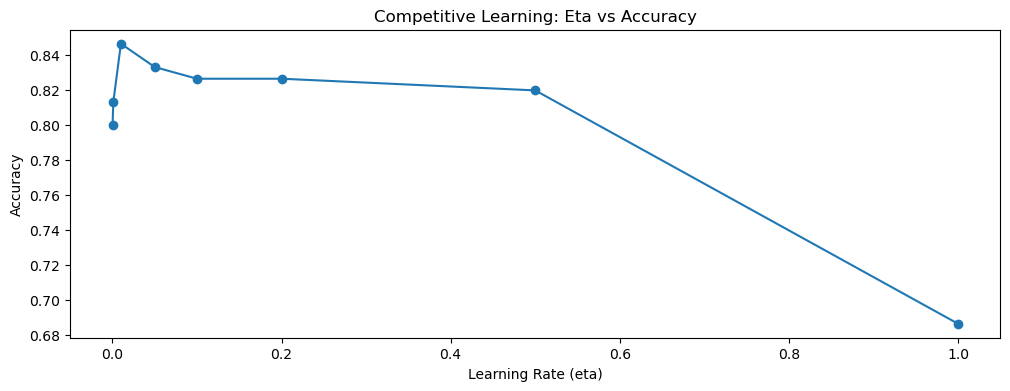

In [47]:
# Competitive learning, varying eta
comp_eta_accuracies = competitive_learning_eta_experiment(iris_normalized, X, etas=[0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0])

plt.figure(figsize=(12, 4))
etas, comp_accuracies = zip(*comp_eta_accuracies)
plt.plot(etas, comp_accuracies, marker='o')
# plt.xscale('log')
plt.xlabel('Learning Rate (eta)')
plt.ylabel('Accuracy')
plt.title('Competitive Learning: Eta vs Accuracy')

### Experiment 2: Effect of epochs/iterations on accuracy

Accuracy reaches its peak of 84.6% after only a few epochs. For k-means, peak accuracy occurs after only 5 epochs. For competitive learning with eta=0.01, peak accuracy is reached at 10 epochs. For competitive learning with eta=0.001, peak accuracy is reached after 50 epochs. Presumably, competitive learning with eta=0.0001 would each 84.6% accuracy eventually, but there is no reason to believe accuracy would go any higher. 

Competitive Learning: eta=0.01, n_epochs=1
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          30         20
Virginica        0           8         42
Accuracy: 0.8133333333333334

Competitive Learning: eta=0.01, n_epochs=5
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          49           1          0
Versicolor       0          35         15
Virginica        0           8         42
Accuracy: 0.84

Competitive Learning: eta=0.01, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          37         13
Virginica        0          10         40
Accuracy: 0.8466666666666667

Competitive Learning: eta=0.01, n_epochs=20
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual

Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          39         11
Virginica        0          14         36
Accuracy: 0.8333333333333334

Competitive Learning: eta=0.001, n_epochs=1
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          29         21
Virginica        0           9         41
Accuracy: 0.8

Competitive Learning: eta=0.001, n_epochs=5
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          30         20
Virginica        0           8         42
Accuracy: 0.8133333333333334

Competitive Learning: eta=0.001, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa

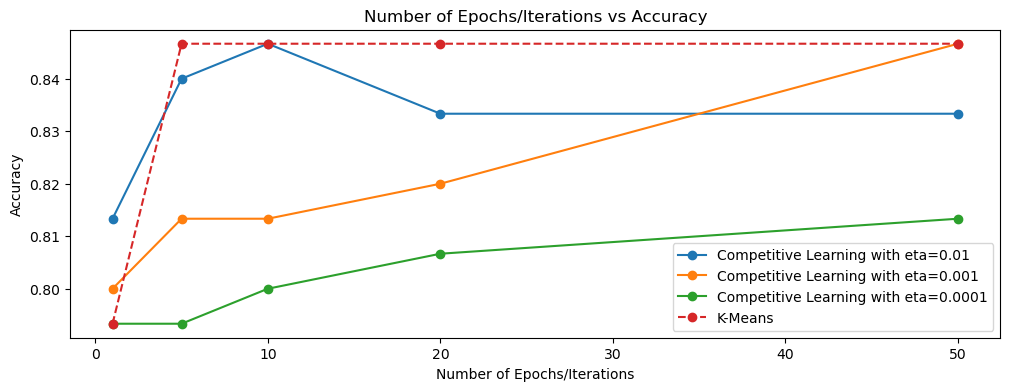

In [48]:
# Competitive learning vs K-Means, varying epochs/iterations

comp_epoch_accuracies_1 = competitive_learning_epochs_experiment(iris_normalized, X, n_epochs_list=[1, 5, 10, 20, 50], eta=0.01)
comp_epoch_accuracies_2 = competitive_learning_epochs_experiment(iris_normalized, X, n_epochs_list=[1, 5, 10, 20, 50], eta=0.001)
comp_epoch_accuracies_3 = competitive_learning_epochs_experiment(iris_normalized, X, n_epochs_list=[1, 5, 10, 20, 50], eta=0.0001) 

kmeans_iters_accuracies = kmeans_iters_experiment(iris_normalized, X, n_iters_list=[1, 5, 10, 20, 50])

plt.figure(figsize=(12, 4))

# Plot competitive learning results for different etas
n_epochs, comp_epoch_accuracies_vals = zip(*comp_epoch_accuracies_1)
plt.plot(n_epochs, comp_epoch_accuracies_vals, marker='o', label='Competitive Learning with eta=0.01')
n_epochs, comp_epoch_accuracies_vals = zip(*comp_epoch_accuracies_2)
plt.plot(n_epochs, comp_epoch_accuracies_vals, marker='o', label='Competitive Learning with eta=0.001')
n_epochs, comp_epoch_accuracies_vals = zip(*comp_epoch_accuracies_3)
plt.plot(n_epochs, comp_epoch_accuracies_vals, marker='o', label='Competitive Learning with eta=0.0001')

# Plot K-Means results for different etas, as dotted line
n_iters, kmeans_accuracies_vals = zip(*kmeans_iters_accuracies)
plt.plot(n_iters, kmeans_accuracies_vals, marker='o', label='K-Means', linestyle='--')

plt.xlabel('Number of Epochs/Iterations')
plt.ylabel('Accuracy')
plt.title('Number of Epochs/Iterations vs Accuracy')
plt.legend()
plt.show()

### Discussion

Of the experiments performed, accuracy never gets higher than 84.6%. The confusion matrices for the configurations with this accuracy are reproduced below:

```
Competitive Learning: eta=0.01, n_epochs=10
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          37         13
Virginica        0          10         40
Accuracy: 0.8466666666666667
==============================

Competitive Learning: eta=0.001, n_epochs=50
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          35         15
Virginica        0           8         42
Accuracy: 0.8466666666666667
==============================

K-Means Clustering: n_iters=5
Confusion Matrix:
Predicted   Setosa  Versicolor  Virginica
Actual                                   
Setosa          50           0          0
Versicolor       0          38         12
Virginica        0          11         39
Accuracy: 0.8466666666666667
==============================
```

Interestingly, though the accuracy seems to have a hard limit, each method/setting converges to a slightly different solution. All three solutions classify the Setosas completely correctly; the misclassifications are exclusively between Versicolors and Virginicas. K-means appears to produce the most even split, meaning that there are equal numbers of Veriscolors misclassified as Virginicas as Virginicas classified as Versicolors. The two competitive learning solutions tend to misclassify Virginicas as Versicolors more often than classifying Versicolors as Virginicas.

The similarity of the solutions should probably not be surprised. K-means, as performed here, is extremely similar to the way that competitive learning works. I initialize the k-means clusters using the same random samples (and the same random seed) that were used to initialize the weights of the competitive network. For both k-means and the competitive network, updating the cluster centers involves some form of averaging between the samples in the cluster and the cluster center. In k-means, samples are associated with the closest cluster center, and then the new cluster center is computed as an average of all of those samples. In competitive learning, the cluster center closest to a single sample is updated as an average between that sample and the cluster center. We can say that competitive learning functions like an online version of k-means; or k-means is like a batched version of competitive learning. The major remaining difference is that competitive learning can accept a learning parameter to adjust how much the cluster centers change at a time.

In this case, it seems that the batched k-means approach arrives at a solution more quickly: the k-means solution converges after 5 epochs, while the competitive learning solution required at least 10.

Looking at the ground truth labels, it makes sense that both methods are having a hard time separating Versicolor and Virginica. The true clusters are close to each other, with a decent amount of overlap. There is not a clear linear boundary between those two groups, which is what these methods do best with.

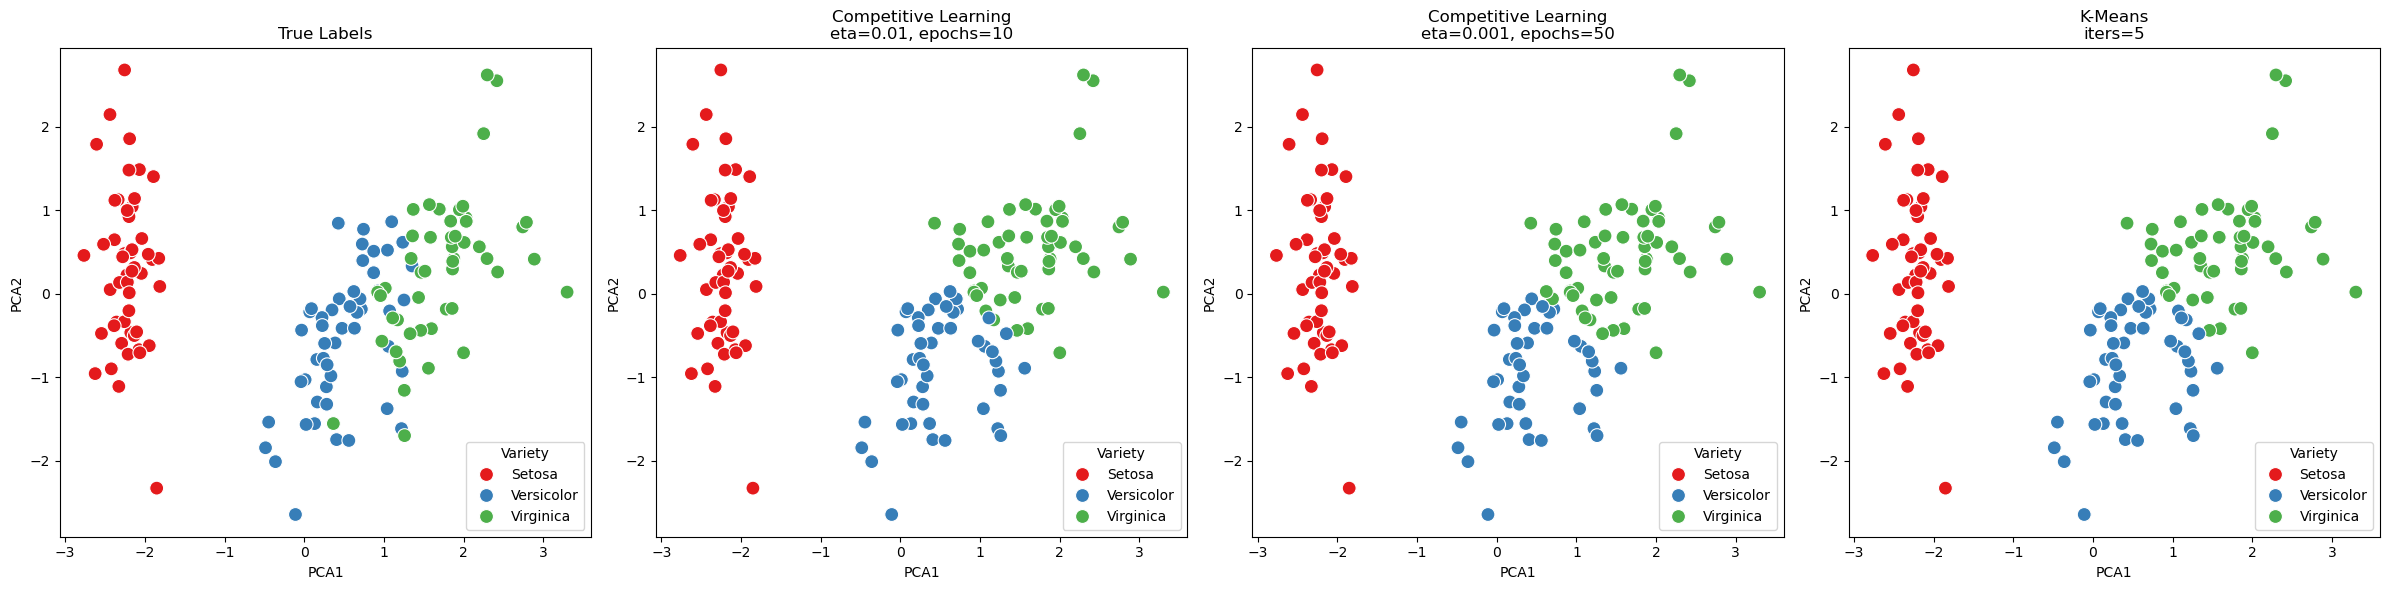

In [81]:
# PCA
X_pca = PCA(n_components=2).fit_transform(X)
iris_normalized['PCA1'] = X_pca[:, 0]
iris_normalized['PCA2'] = X_pca[:, 1]


# Plot clusters for each solution
solution_labels = [
    ("True Labels", "variety"),
    ("Competitive Learning\neta=0.01, epochs=10", "variety_pred_competitive_0.01_10"),
    ("Competitive Learning\neta=0.001, epochs=50", "variety_pred_competitive_0.001_50"),
    ("K-Means\niters=5", "variety_pred_kmeans_5")
]

name_order = ["Setosa", "Versicolor", "Virginica"]

fig, axes = plt.subplots(1, 4, figsize=(24, 6))
for i, label in enumerate(solution_labels):
    ax = axes[i]
    sns.scatterplot(data=iris_normalized, x='PCA1', y='PCA2',
                    hue=label[1], hue_order=name_order, palette='Set1', s=100, ax=ax)
    ax.set_title(f'{label[0]}')
    ax.legend(title="Variety")

plt.tight_layout()
plt.show()